# UBI Test

A visualisation of how a Universal Basic Income Transfer affects the income distribution throughout time, when accounting for investment income and capital accumulation.

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

```python
import matplotlib.pyplot as plt

def plot_distribs(ubi_array, x=250):
    # Set the figure size
    plt.figure(figsize=(18, 6))  # Width: 12 inches, Height: 6 inches
    colors = plt.cm.viridis(np.linspace(0, 1, len(ubi_array)))
    # Plot the bar chart
    for i, df in enumerate(ubi_array):
        df = df.drop(df[df['Income Range'].str.split('-').str[-1].astype(int) > x*1000].index)
        plt.bar(range(len(df)), df["Number of People"], color = colors[i] )
        
    # Set x-tick positions to every fifth element
    plt.xticks(np.arange(0, len(df), 5))

    tick_labels = [df["Income Range"].iloc[i] if i % 25 == 0 else '' for i in range(0,len(df),5)]
    plt.xticks(rotation=90)  # Rotate labels for better readability
    plt.gca().set_xticklabels(tick_labels)

    # Add labels and title
    plt.xlabel('Income Range, Thousands')
    plt.ylabel('Number of People')
    plt.title('Frequency Chart of Income Distribution')

    # Show plot
    plt.show()


In [30]:
#Choose number of periods to model
I = 5

## The Starting Income Distribution

### Generate the Distribution

Here, I synthetically generate a log-normal distribution, given strong empirical evidence backing the principle that a log-normal is a strong approximation for the observed/empirical income distribution.

In [44]:

# Desired mean and mode (peak)
mean_X = 50000  # Desired meabn
mode_X = 25000  # Desired mode (peak)
pop = 1*(10**3) # Desired population

# Calculate parameters for the log-normal distribution
sigma_log = np.sqrt(np.log(1 + ((mode_X / mean_X)**2)))
mu_log = np.log(mean_X) - (0.5 * sigma_log**2)

# Generate random numbers following a log-normal distribution
random_numbers = np.random.lognormal(mu_log, sigma_log, pop)

# Get the income of the richest person
max_inc = max(random_numbers)

# Define income range increments
income_increments = np.arange(0, max(random_numbers) + 1000, 1000)

# Create frequency table using NumPy's histogram function
frequencies, bins = np.histogram(random_numbers, bins=income_increments)

# Create a DataFrame from the frequency table
frequency_df = pd.DataFrame({'Income Range': [f'${int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins) - 1)],
                             'Number of People': frequencies})





### Visualise the Income Distribution

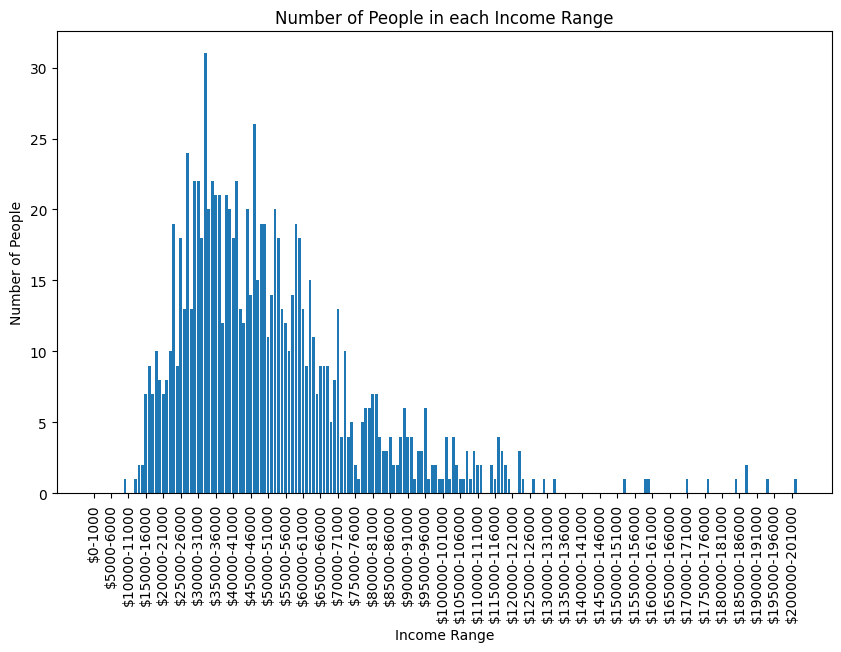

In [45]:


plt.figure(figsize=(10,6)) #set the figu
plt.bar(frequency_df['Income Range'], frequency_df['Number of People']) # add the bar series
plt.xticks(frequency_df['Income Range'][::5], rotation = 90) # rotate th

plt.xlabel('Income Range') # set the x label
plt.ylabel('Number of People') # set y label
plt.title('Number of People in each Income Range') # set the title 
plt.show()


## Starting Wealth/Capital Stock

Because savings rates are higher at higher levels of income, yet the savings rate must reach a limit (even the highest income person here is assumed to only save 90% of their additional income), I stipulate that the marginal savings rate is an increasing yet concave function of income, reaching a limit of 0.9 for the person who has the highest starting income.

### Define A Concave Function of Income That Represents the Savings Rate

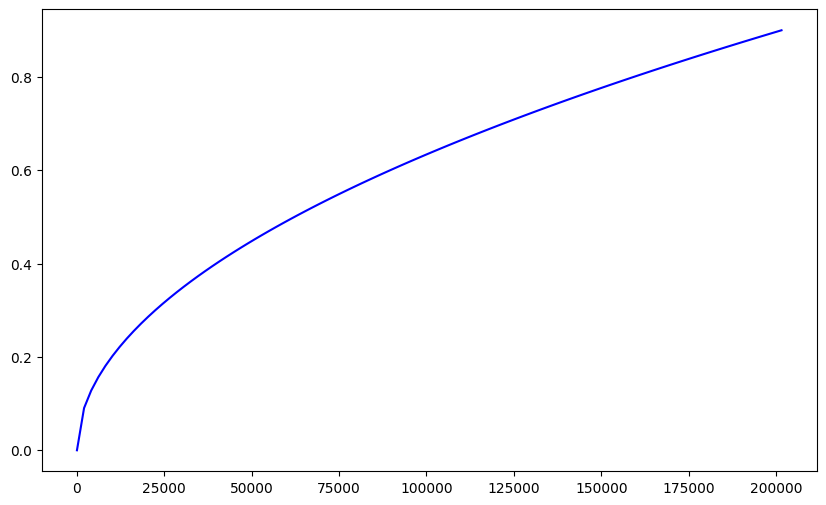

In [ ]:

def savings_rate(x):
    return 0.9 * np.sqrt(x / max_inc)
# visualtise how this function appears for x in the range 0 to the max income
x_values = np.linspace(0, max_inc, 100)
y_values = savings_rate(x_values)
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Savings Rate', color='blue')


### Define A Function Representing the Total Saved Each Year for Each Income

This is simply the integral of the previous function with respect to the starting income, which results in an increasing and convex function with respect to income (both income and savings rate increase with income, so the total annual savings rise rapidly with income)

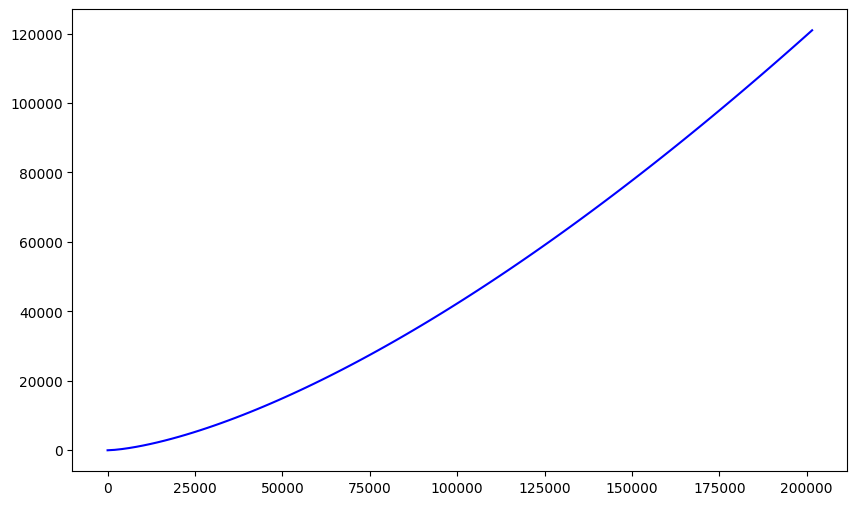

In [ ]:
def saved_per_year(x):
    return (0.9/1.5) * (1/np.sqrt(max_inc)) * (x ** (1.5))
# visualtise how this function appears for x in the range 0 to the max income
x_values = np.linspace(0, max_inc, 100)
y_values = saved_per_year(x_values)
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Saved Per Year', color='blue')

### Generate The Starting Wealth

Combining a higher amount of annual savings with interest applied over a number of years, we have the following final function:

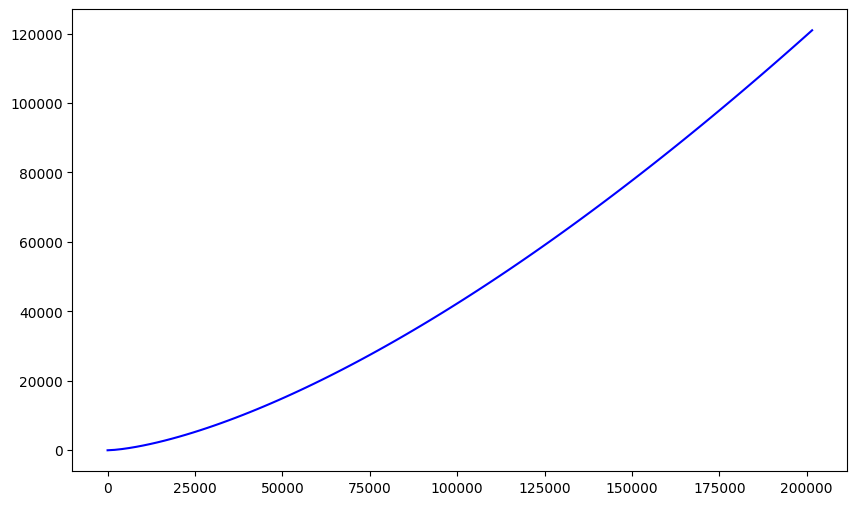

In [58]:
def starting_wealth(x, r=0.07, n=5):
    # Compound each year's savings for the appropriate number of years
    # saved_per_year(x) is the amount saved each year
    # For year k (0-based), it is compounded (n-k) times
    return sum(saved_per_year(x) * (1 + r) ** (n - k) for k in range(n))
# visualise how this function appears for x in the range 0 to the max income
x_values = np.linspace(0, max_inc, 100)
y_values = saved_per_year(x_values)
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Starting Wealth', color='blue')

## Define a function that iteratively generates variables cols for each period

In [86]:
data = pd.DataFrame({'lab_income_1': random_numbers})


def gen_period_i(data = data, i = 1, tax = 0.2, r = 0.07, s=0.2, a =0.4):
    covered_columns = []
    
    for x in range(1, i+1, 1):
        # Recalculate income range increments for each period based on current period's income
        current_max_income = max(data['lab_income_' + str(x)]) if 'lab_income_' + str(x) in data.columns else max(data['lab_income_1'])
        income_increments = np.arange(0, current_max_income + 1000, 1000)
        
        # Create frequency table using NumPy's histogram function for current period
        frequencies, bins = np.histogram(data['lab_income_' + str(x)] if 'lab_income_' + str(x) in data.columns else data['lab_income_1'], bins=income_increments)
        
        # Create a DataFrame from the frequency table for current period
        frequency_df = pd.DataFrame({'Income Range': [f'${int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins) - 1)],
                                    'Number of People': frequencies}) 
        # Calculate starting wealth for each individual based on their initial labour income
        data['capital_1'] = starting_wealth(data['lab_income_1'])
        # Calculate investment income for period x
        data['inv_income_' + str(x)] = r * data['capital_' + str(x)]
        # Total income is labour income plus investment income for period x
        data['income_' + str(x)] = data['lab_income_' + str(x)] + data['inv_income_' + str(x)]
        # Categorise labour income into income bins for current period
        data['category_' + str(x)] = pd.cut(data['lab_income_' + str(x)] if 'lab_income_' + str(x) in data.columns else data['lab_income_1'], bins=bins, labels=frequency_df['Income Range'])
        # Calculate tax for period x (applied to total income plus investment income)
        data['tax_' + str(x)] = (data['income_' + str(x)] + data['inv_income_' + str(x)]) * tax
        # Calculate UBI amount for period x (redistribute 100a% of total tax revenue equally)
        data['ubi_amount_' + str(x)] = (a * sum(data['tax_' + str(x)])) / pop
        # Net transfer is UBI received minus tax paid for period x
        data['net_transfer_' + str(x)] = data['ubi_amount_' + str(x)] - data['tax_' + str(x)]
        # Disposable income is total income plus net transfer and investment income for period x
        data['disposable_income_' + str(x)] = (data['income_' + str(x)] + data['net_transfer_' + str(x)] + data['inv_income_' + str(x)])
        # Income available to spend after saving for period x
        data['income_to_spend_' + str(x)] = (1-savings_rate(data['disposable_income_' + str(x)])) * data['disposable_income_' + str(x)]
        # Amount invested (saved) for period x
        data['inv_' + str(x)] = savings_rate(data['disposable_income_' + str(x)]) * data['disposable_income_' + str(x)]
        
        # Categorise all relevant columns into bins for period x (supports visualisation)
        for col in data.columns:
            if col not in ['category_' + str(y) for y in range(1, i+2)] and col != 'lab_income_' + str(x+1) and col not in covered_columns:
                cat_col = (col[:-2] + '_category_' + str(x)) # get the base name of the column and append '_category_x'
                
                # Find the current range and increments for this column
                current_col_max = max(data[col])
                #current_col_min = 0
                current_col_min = min(data[col])

                current_col_increments = np.arange(current_col_min-1000, current_col_max + 1000, 1000)

                # Create frequency table using NumPy's histogram function
                col_frequencies, col_bins = np.histogram(data[col], bins=current_col_increments)

                # Create a DataFrame from the frequency table
                col_frequency_df = pd.DataFrame({'Range': [f'${int(col_bins[i])}-{int(col_bins[i+1])}' for i in range(len(col_bins) - 1)],
                                            'Number of People': col_frequencies})
                data[cat_col] = pd.cut(data[col], bins=col_bins, labels=col_frequency_df['Range']) #group the data by these categories
                covered_columns.append(col) # append the column to the covered columns list
                covered_columns.append(cat_col) # append the category column to the covered columns list
                        
        # Update capital for next period by adding new investment
        data['capital_' + str(x+1)] = data['capital_' + str(x)] + data['inv_' + str(x)] 
        # Update labour income for next period, accounting for productivity gains from investment
        data['lab_income_' + str(x+1)] = data['lab_income_' + str(x)] + ((1-a)/a) * r * data['capital_' + str(x+1)]
        
    return data
# Display the DataFrame
data = gen_period_i(i=I)



In [87]:
data

,lab_income_1,capital_1,inv_income_1,income_1,category_1,tax_1,ubi_amount_1,net_transfer_1,disposable_income_1,income_to_spend_1,...,inv_income_category_5,income_category_5,tax_category_5,ubi_amount_category_5,net_transfer_category_5,disposable_income_category_5,income_to_spend_category_5,inv_category_5,capital_6,lab_income_6
0,49088.688745,89439.150136,6260.740510,55349.429254,$49000-50000,12322.033953,5256.574392,-7065.459561,54544.710203,29007.803020,...,$19080-20080,$146986-147986,$32413-33413,$14713-15713,$-18419--17419,$148367-149367,$33102-34102,$115218-116218,393894.336452,168901.105033
1,29201.787595,41036.439580,2872.550771,32074.338366,$29000-30000,6989.377827,5256.574392,-1732.803435,33214.085701,21079.560363,...,$8080-9080,$72986-73986,$16413-17413,$14713-15713,$-1419--419,$81367-82367,$34102-35102,$46218-47218,170538.502869,82673.705602
2,9733.518764,7896.966986,552.787689,10286.306453,$9000-10000,2167.818828,5256.574392,3088.755563,13927.849705,10632.773617,...,$1080-2080,$18986-19986,$3413-4413,$14713-15713,$10580-11580,$32367-33367,$21102-22102,$11218-12218,41935.035339,22309.822711
3,51114.098224,95031.278384,6652.189487,57766.287711,$51000-52000,12883.695440,5256.574392,-7627.121048,56791.356150,29660.549941,...,$20080-21080,$154986-155986,$34413-35413,$14713-15713,$-20419--19419,$156367-157367,$32102-33102,$124218-125218,422206.014311,179056.317525
4,35338.661052,54629.931060,3824.095174,39162.756226,$35000-36000,8597.370280,5256.574392,-3340.795888,39646.055512,23821.215899,...,$11080-12080,$93986-94986,$20413-21413,$14713-15713,$-6419--5419,$99367-100367,$36102-37102,$63218-64218,229182.845977,106678.870400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,33399.410646,50195.377178,3513.676402,36913.087049,$33000-34000,8085.352690,5256.574392,-2828.778298,37597.985153,22983.409894,...,$10080-11080,$86986-87986,$19413-20413,$14713-15713,$-4419--3419,$93367-94367,$36102-37102,$57218-58218,209685.935124,98841.844650
996,53255.441444,101065.167525,7074.561727,60330.003171,$53000-54000,13480.912980,5256.574392,-8224.338588,59180.226310,30319.698298,...,$22080-23080,$163986-164986,$36413-37413,$14713-15713,$-22419--21419,$164367-165367,$30102-31102,$134218-135218,453307.710973,190071.351115
997,57296.973748,112785.441368,7894.980896,65191.954644,$57000-58000,14617.387108,5256.574392,-9360.812716,63726.122824,31477.172419,...,$25080-26080,$181986-182986,$41413-42413,$14713-15713,$-26419--25419,$181367-182367,$26102-27102,$155218-156218,515336.213569,211644.896020
998,44064.337396,76065.265004,5324.568550,49388.905947,$44000-45000,10942.694899,5256.574392,-5686.120508,49027.353989,27265.443361,...,$16080-17080,$125986-126986,$28413-29413,$14713-15713,$-13419--12419,$129367-130367,$35102-36102,$93218-94218,328224.506639,144810.044197


In [10]:
pd.set_option("display.max_rows", 10) 

## Define a function that makes pivot tables for sum of a variable grouped by income_category_1

In [11]:
def make_groups(data, x =1, coltypes = ['lab_income_', 'inv_income_']):
    columns = [(col + str(x)) for col in coltypes]
    grouped_df = data.pivot_table(values = columns, index = 'income_category_' + str(x), aggfunc = 'sum', observed=False)
    return(grouped_df)
    
    
make_groups(data).iloc[100:120]

,inv_income_1,lab_income_1
income_category_1,,
$100000-101000,54716.919825,246454.352579
$101000-102000,37126.465207,166245.021990
$102000-103000,0.000000,0.000000
$103000-104000,94781.944975,421459.952848
$104000-105000,57817.143816,255678.032751
...,...,...
$115000-116000,0.000000,0.000000
$116000-117000,89394.125914,376277.560992
$117000-118000,45291.367443,189802.899732


## Define a function that makes an array of dataframes, 
1 for each period, each with one column which is each income category, and the others are the sums of other variables that are in each category/grouped by each category

In [12]:
def gen_ubi_array(data=data, i=1, coltypes = ['lab_income_', 'inv_income_']):
    ubi_array = []
    for x in range(1, i + 1):  # Corrected the range to include i
        grouped_df = make_groups(data, x=x, coltypes = coltypes).reset_index()
        ubi_array.append(grouped_df)
    return ubi_array
        
        
gen_ubi_array(i = I, coltypes = ['lab_income_', 'inv_income_', 'net_transfer_'])[1]

,income_category_2,inv_income_2,lab_income_2,net_transfer_2
0,$0-1000,0.0,0.0,0.0
1,$1000-2000,0.0,0.0,0.0
2,$2000-3000,0.0,0.0,0.0
3,$3000-4000,0.0,0.0,0.0
4,$4000-5000,0.0,0.0,0.0
...,...,...,...,...
250,$250000-251000,0.0,0.0,0.0
251,$251000-252000,0.0,0.0,0.0
252,$252000-253000,0.0,0.0,0.0
253,$253000-254000,0.0,0.0,0.0


In [13]:
UBI = gen_ubi_array(i = I)

## Define and use a function that plots the distribution of the categorised variables for one of the periods in the ubi dataframe

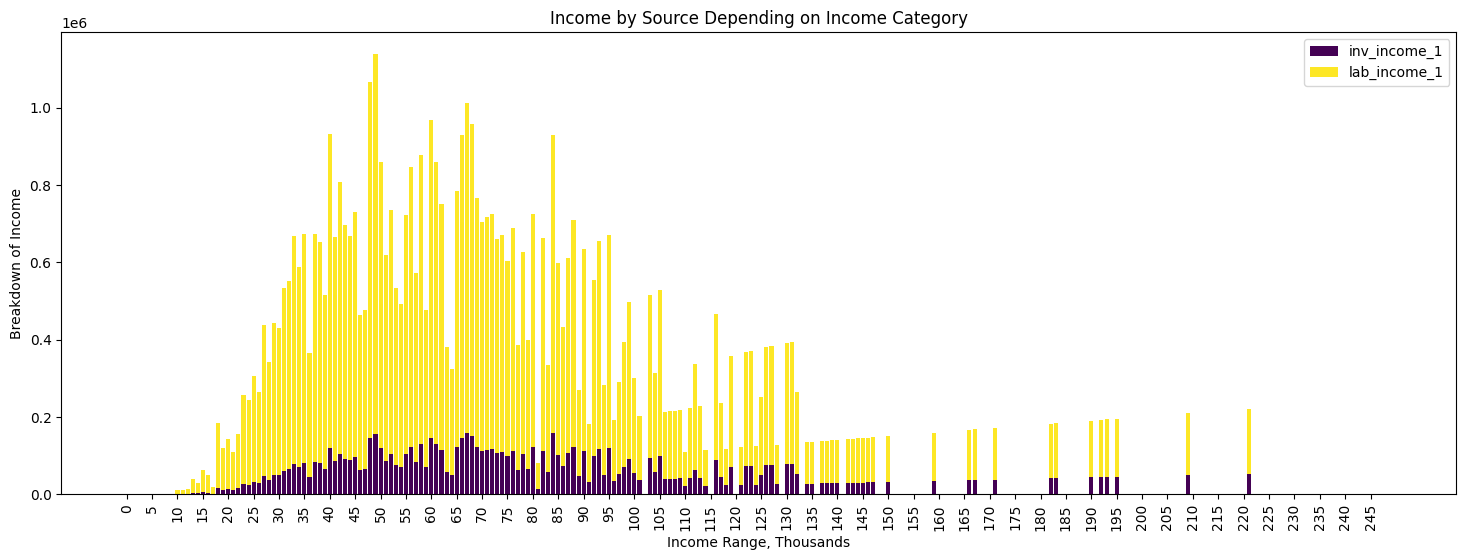

In [14]:
def plot_ubi(ubi, x=250, i = 0, coltype = 'income_category'):
        # Set the figure size
        plt.figure(figsize=(18, 6))  # Width: 12 inches, Height: 6 inches
        
        df = ubi
        df = df.drop(df[df[coltype + '_' + str(i+1)].str.split('-').str[-1].astype(int) > x*1000].index)
        bottom = None
        num_bars = len(ubi.columns[1:])
        colors = plt.cm.viridis(np.linspace(0, 1, num_bars))  # Generate a range of colors from yellow to red
        nth_bar = 0
        for n, col in enumerate(df.columns[1:]):
                if n == 0:
                    plt.bar(range(len(df)), df[col], color=colors[nth_bar], label=str(col))  # Use color from the gradient
                    bottom = df[col]  # Update the bottom values for subsequent sets of bars
                    nth_bar += 1
                else:
                    plt.bar(range(len(df)), df[col], bottom=bottom, color=colors[nth_bar], label=str(col))  # Use color from the gradient
                    bottom += df[col]  # Update the bottom values for subsequent sets of bars
                    nth_bar += 1

        # Set x-tick positions to every fifth element
        plt.xticks(np.arange(0, len(df), 5))


        #tick_labels = [df["Income Range"].iloc[i] if i % 25 == 0 else '' for i in range(0,len(df),5)]
        plt.xticks(rotation=90)  # Rotate labels for better readability
        #plt.gca().set_xticklabels(tick_labels)

        # Add labels and title
        plt.xlabel('Income Range, Thousands')
        plt.ylabel('Breakdown of Income')
        plt.title('Income by Source Depending on Income Category')
        plt.legend()

        # Show plot
        plt.show()
    
plot_ubi(ubi = UBI[0])

10


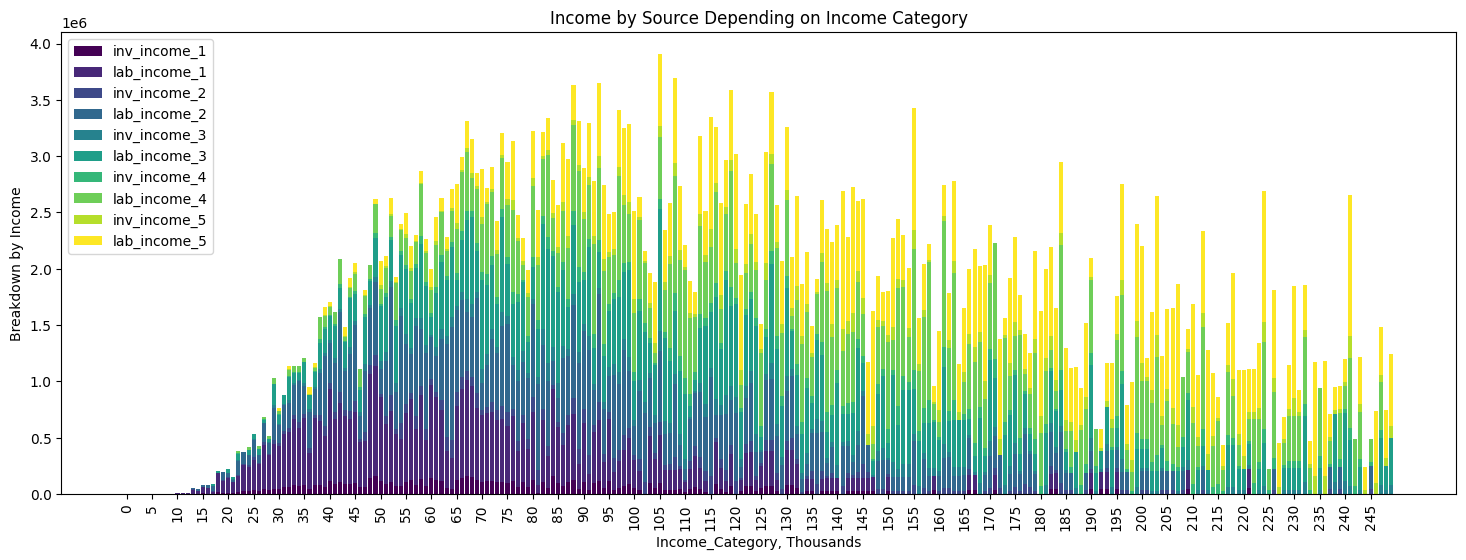

In [15]:


def plot_ubis(ubi_array, separate=True, x=250, coltype = 'income_category'):
    if separate:
        for i, df in enumerate(ubi_array):
            plot_ubi(df, i=i)
    else:
        plt.figure(figsize=(18, 6))
        bottom = None
        num_bars = len(ubi_array) * len(ubi_array[0].columns[1:])
        print(num_bars)
        colors = plt.cm.viridis(np.linspace(0, 1, num_bars))  # Generate a range of colors from yellow to red
        nth_bar = 0
        for i, df in enumerate(ubi_array):
            df = df.drop(df[df[coltype + '_' + str(i + 1)].str.split('-').str[-1].astype(int) > x * 1000].index) # drop all incomes above 250k
            for n, col in enumerate(df.columns[1:]):
                if n == 0:
                    if i == 0:
                        plt.bar(range(len(df)), df[col], color=colors[nth_bar], label=str(col))  # Use color from the gradient
                        bottom = df[col]  # Update the bottom values for subsequent sets of bars
                    else:
                        plt.bar(range(len(df)), df[col], bottom=bottom, color=colors[nth_bar], label=str(col))  # Use color from the gradient
                        bottom += df[col]  # Update the bottom values for subsequent sets of bars
                    nth_bar += 1
                else:
                    plt.bar(range(len(df)), df[col], bottom=bottom, color=colors[nth_bar], label=str(col))  # Use color from the gradient
                    bottom += df[col]  # Update the bottom values for subsequent sets of bars
                    nth_bar += 1
        
        plt.xticks(np.arange(0, len(df), 5))
        plt.xticks(rotation=90)
        plt.xlabel(f'{str.title(coltype)}, Thousands')
        plt.ylabel('Breakdown by Income')
        plt.title('Income by Source Depending on Income Category')
        plt.legend()
        plt.show()

# Assuming x is defined elsewhere in your code
plot_ubis(UBI, separate=False)


## Generate summary statistics in a new table

In [16]:
data.agg([max, min])

C:\Users\danie\AppData\Local\Temp\ipykernel_12168\3448160133.py:1: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data.agg([max, min])
C:\Users\danie\AppData\Local\Temp\ipykernel_12168\3448160133.py:1: FutureWarning: The provided callable <built-in function min> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  data.agg([max, min])


,lab_income_1,capital_1,inv_income_1,income_1,category_1,tax_1,ubi_amount_1,net_transfer_1,disposable_income_1,income_to_spend_1,...,inv_income_category_5,income_category_5,tax_category_5,ubi_amount_category_5,net_transfer_category_5,disposable_income_category_5,income_to_spend_category_5,inv_category_5,capital_6,lab_income_6
max,254886.325761,498385.541747,99677.108349,354563.434110,$254000-255000,90848.108492,5531.193697,3264.507859,368923.627665,-11678.349638,...,$204000-205000,$253000-254000,$211000-212000,$16000-17000,$9000-10000,$254000-255000,NaN,$172000-173000,1.278399e+06,1.567132e+06
min,9824.775457,3771.634327,754.326865,10579.102323,$9000-10000,2266.685838,5531.193697,-85316.914795,14597.937047,-295138.902132,...,$4000-5000,$30000-31000,$7000-8000,$16000-17000,$0-1000,$44000-45000,NaN,$8000-9000,3.109470e+04,3.559814e+04


In [17]:
gov_rev = np.zeros(I)

def summary_stats(data = data, cols=['tax', 'income', 'inv_income', 'lab_income'], periods=I, aggfuncs = 'sum'):
    # Create an empty DataFrame to store the summary stats
    col_df = pd.DataFrame(index=range(periods))
    for col in cols:
        for i in range(periods):
            # Calculate the sum of the column for each period and store it in the DataFrame
            for aggfunc in aggfuncs:
                col_df.at[i, col + '_' + aggfunc] = data[col + '_' + str(i+1)].agg(aggfunc)

    return col_df

# Assuming 'data' and 'I' are defined elsewhere in your code
summary_data = summary_stats(cols = ['income'], aggfuncs = ['mean', 'min', 'max'])
print(summary_data)


     income_mean    income_min    income_max
0   59664.979136  10579.102323  3.545634e+05
1   79961.705316  13170.386325  5.409715e+05
2  105909.299059  17073.406281  7.657899e+05
3  139275.614392  22720.172251  1.042429e+06
4  182344.670764  30700.966878  1.387692e+06


## Define a function that plots summary statistics accross time

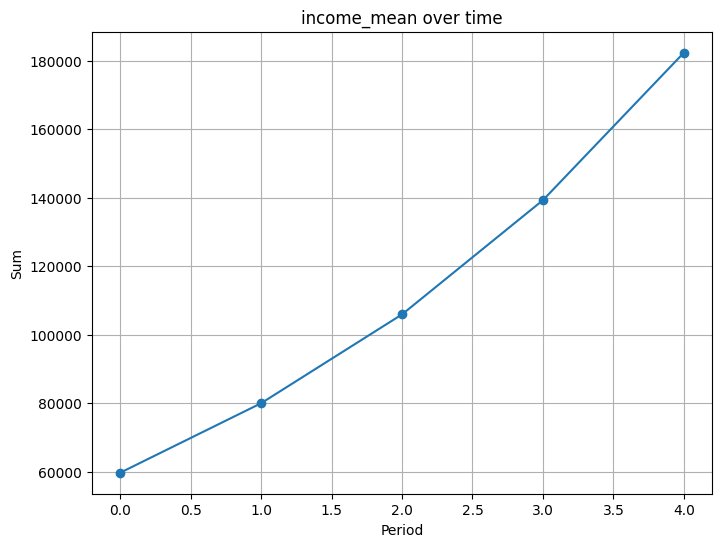

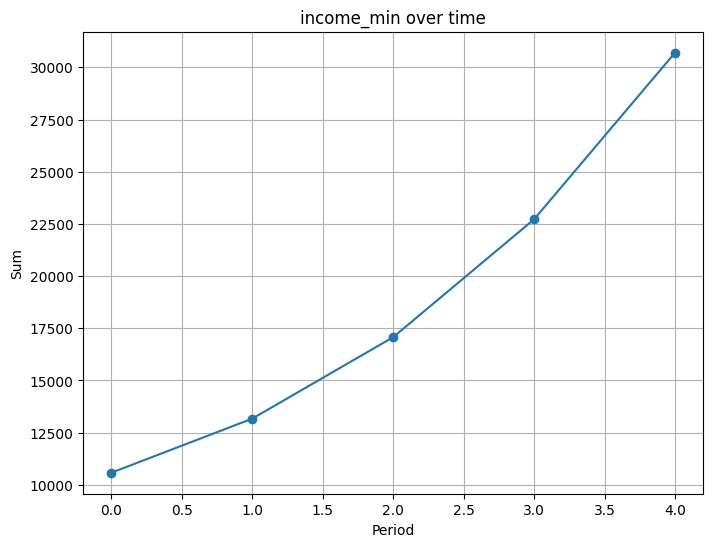

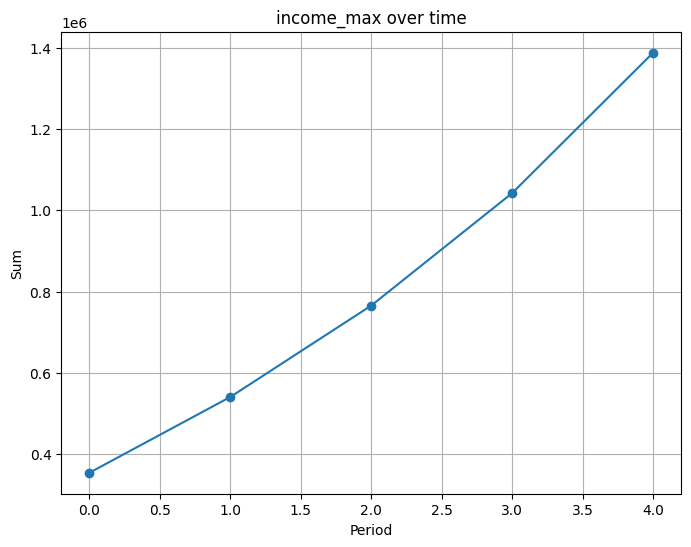

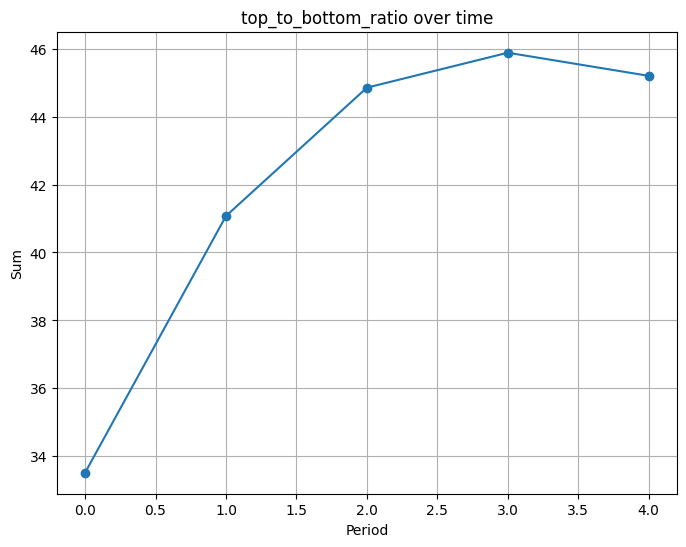

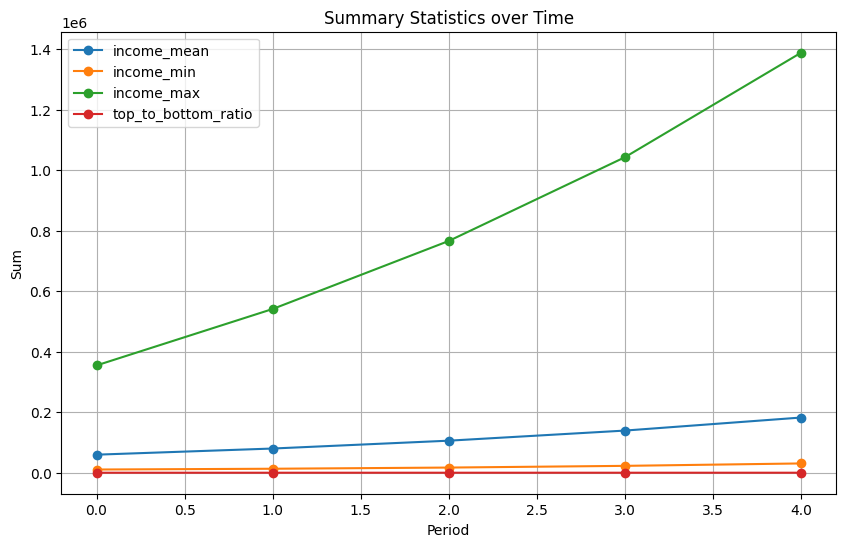

In [18]:


def plot_summary_stats(summary_data = summary_data):
    # Plot each column separately
    for col in summary_data.columns:
        plt.figure(figsize=(8, 6))
        plt.plot(summary_data.index, summary_data[col], marker='o', linestyle='-')
        plt.title(col + ' over time')
        plt.xlabel('Period')
        plt.ylabel('Sum')
        plt.grid(True)
        plt.show()

    # Plot all columns together on one subplot
    plt.figure(figsize=(10, 6))
    for col in summary_data.columns:
        plt.plot(summary_data.index, summary_data[col], marker='o', linestyle='-', label=col)
    plt.title('Summary Statistics over Time')
    plt.xlabel('Period')
    plt.ylabel('Sum')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming 'summary_data' DataFrame is obtained from the previous step
summary_data['top_to_bottom_ratio'] = summary_data.income_max/summary_data.income_min
plot_summary_stats(summary_data)


## Define a function that makes a frequency table of a given column type

In [19]:
def make_freq_table(coltype = 'income_category', i = 1):
    ubi = data[str(coltype) + '_' + str(i)].value_counts().reset_index()
    ubi.columns = [coltype, 'Number of People']

    # Sort the frequency table by income range
    ubi = ubi.sort_values(by=coltype)
    # Display the frequency table
    return(ubi)


## Generate multiple frequency tables

### Test for each i

In [20]:
ubi1 = make_freq_table(i=1)
ubi2 = make_freq_table(i=2)
ubi3 = make_freq_table(i=3)
ubi4 = make_freq_table(i=4)
ubi5 = make_freq_table(i=5)

### Define a function that does the above cell in one go

In [21]:
def ubi_multiple(data = data, i=1, coltype = 'income_category'):
    ubi_multiple = []
    print(ubi_multiple)
    for x in range(0,i):
        ubi_multiple.append(make_freq_table(i = x+1, coltype = coltype))
        
    return ubi_multiple
#ubi_multiple(i=5)

## Plot the distributions of different variables

[]


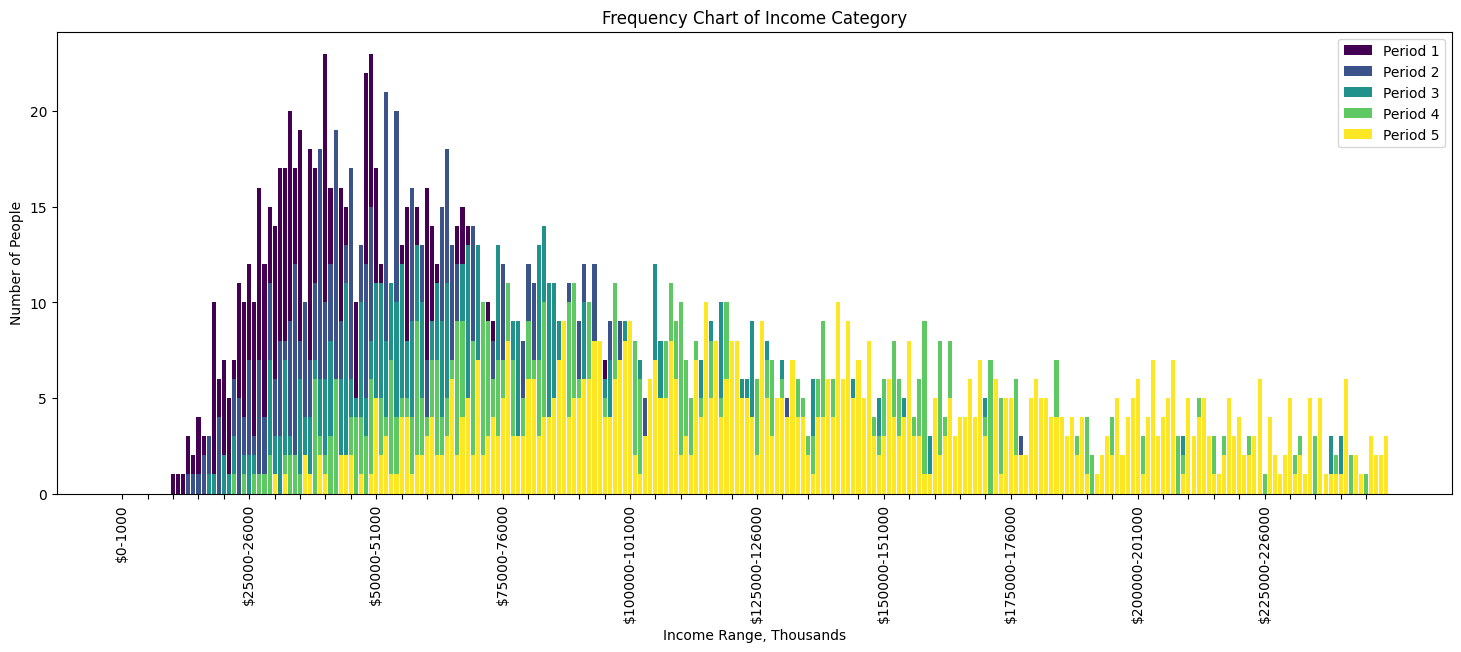

In [22]:
def plot_distribs(ubi_array, x=250, coltype = 'income_category'):
    # Set the figure size
    plt.figure(figsize=(18, 6))  # Width: 12 inches, Height: 6 inches
    colors = plt.cm.viridis(np.linspace(0, 1, len(ubi_array)))
    # Plot the bar chart
    for i, df in enumerate(ubi_array):
        df = df.drop(df[df[coltype].str.split('-').str[-1].astype(int) > x*1000].index)
        plt.bar(range(len(df)), df["Number of People"], color = colors[i], label = 'Period ' + str(i+1))
        
    # Set x-tick positions to every fifth element
    plt.xticks(np.arange(0, len(df), 5))

    tick_labels = [df[coltype].iloc[i] if i % 25 == 0 else '' for i in range(0,len(df),5)]
    plt.xticks(rotation=90)  # Rotate labels for better readability
    plt.gca().set_xticklabels(tick_labels)

    # Add labels and title
    plt.xlabel('Income Range, Thousands')
    plt.ylabel('Number of People')
    plt.title('Frequency Chart of ' + coltype.replace('_',' ').title())
    plt.legend()

    # Show plot
    plt.show()

plot_distribs(ubi_multiple(i=I))

[]


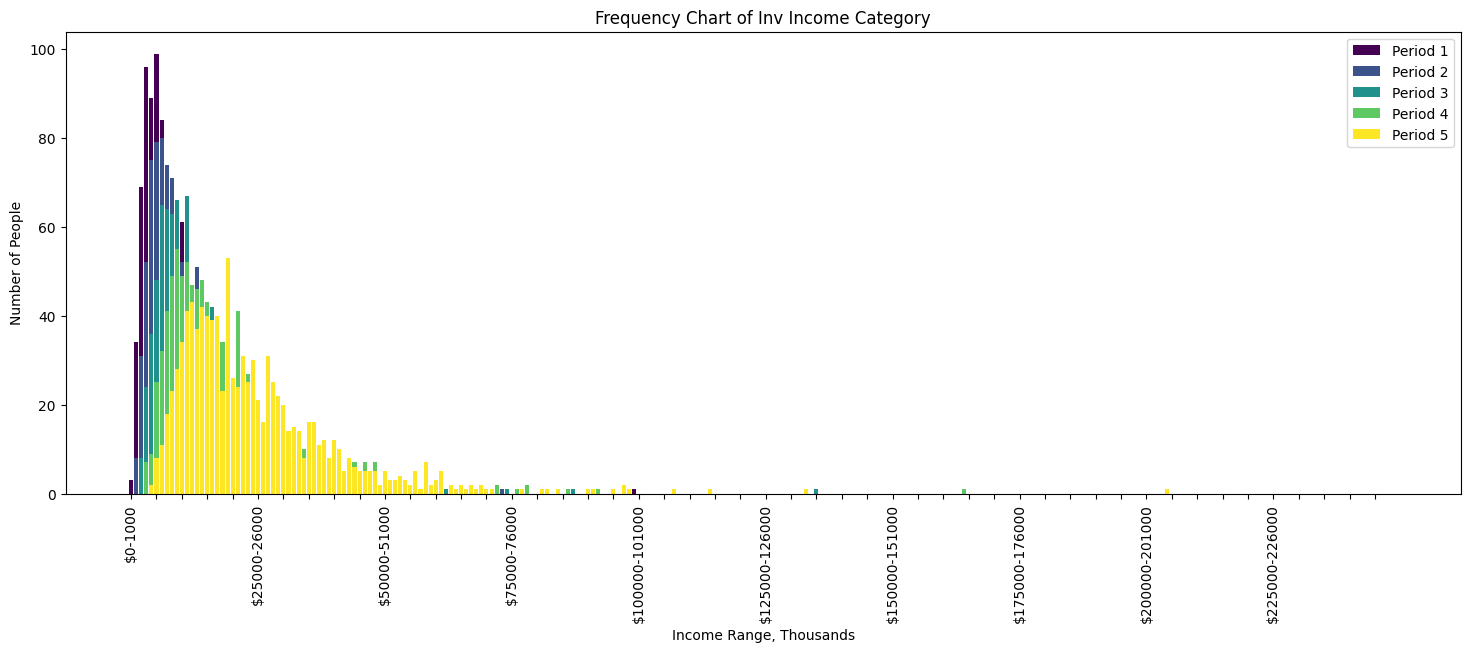

[]


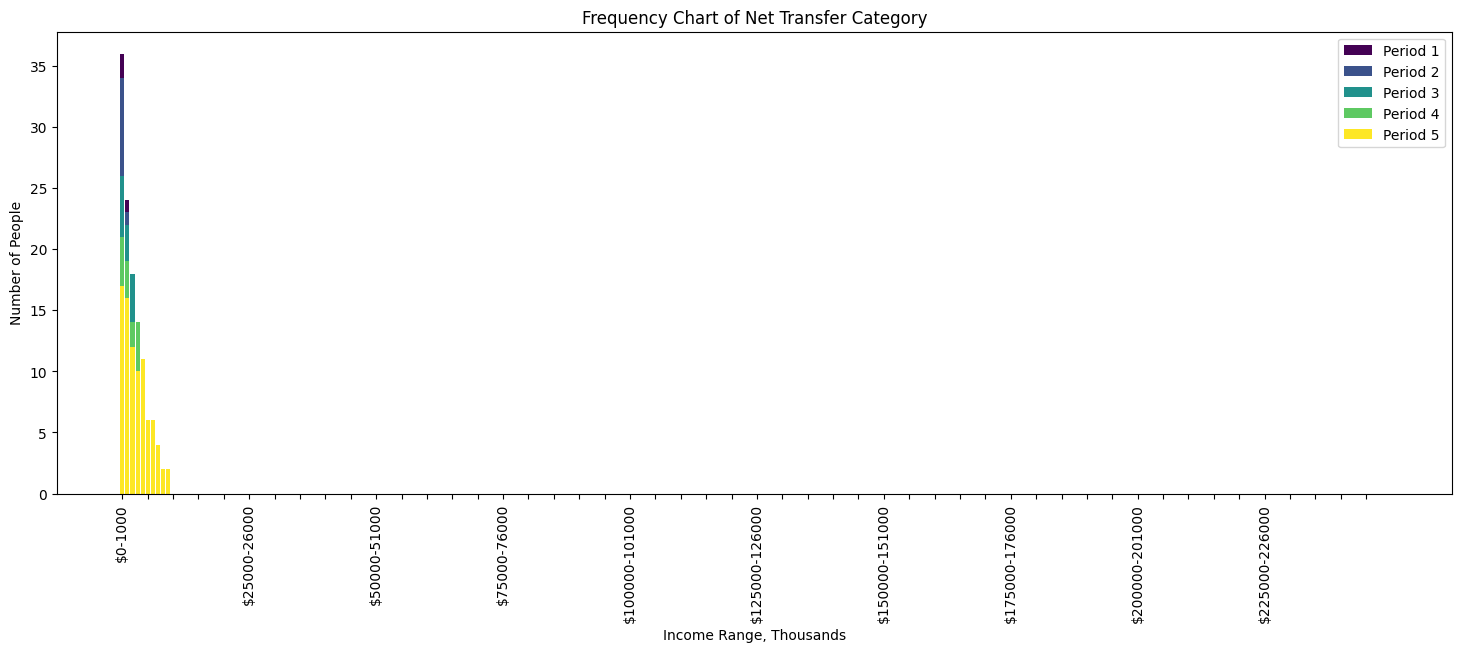

[]


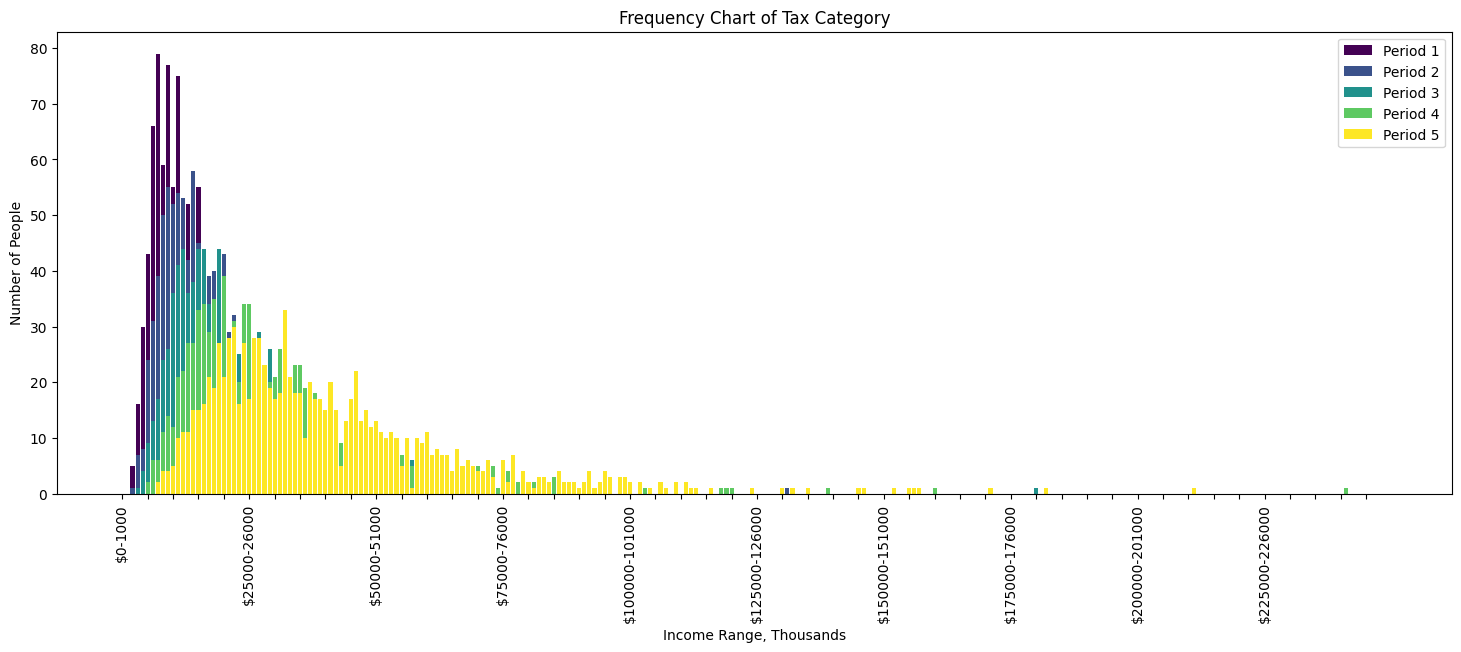

In [23]:
cols_list = ['inv_income_category','net_transfer_category', 'tax_category']
for coltype in cols_list:
    plot_distribs(ubi_multiple(i=I, coltype = coltype),coltype = coltype)

[]


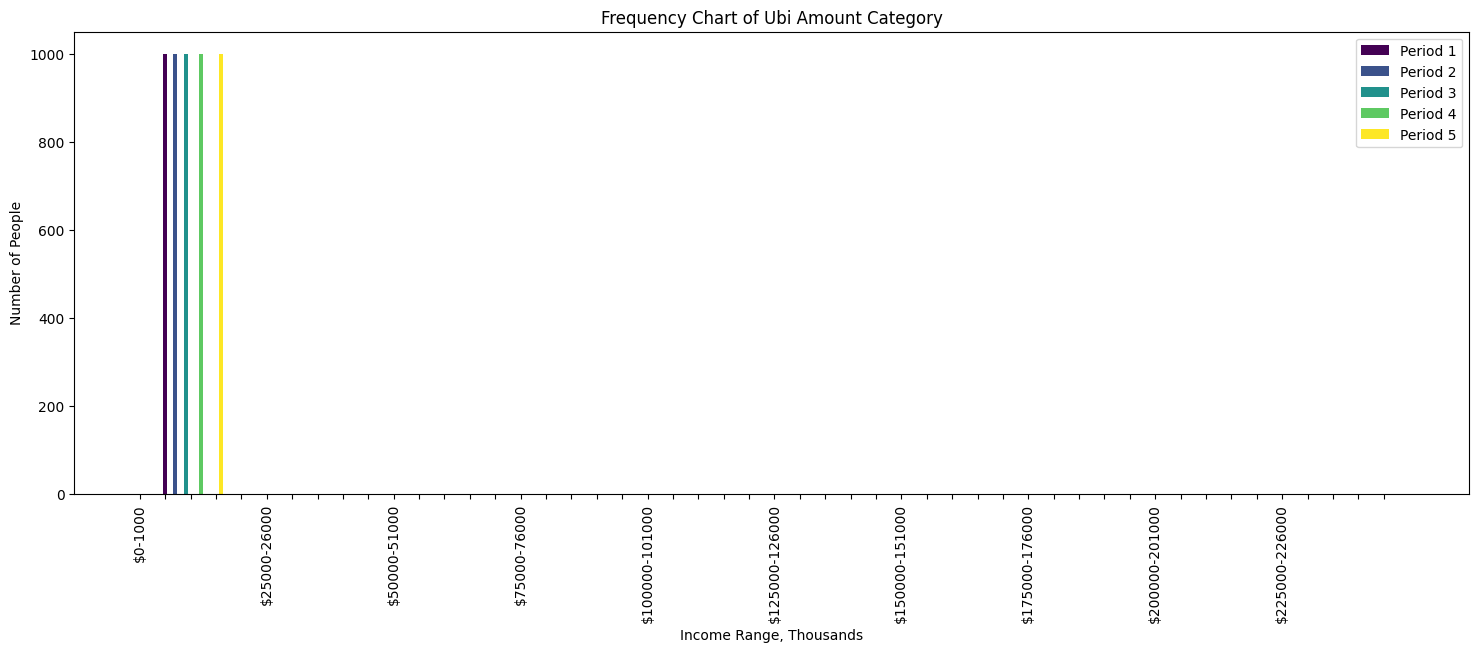

In [24]:
cols_list = ['ubi_amount_category']
for coltype in cols_list:
    plot_distribs(ubi_multiple(i=I, coltype = coltype),coltype = coltype)